# EOF Analysis of AR days

* Multivariate EOF analysis in T-mode
* K-means clustering

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_ERAI_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice('1979-01-01', '2018-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### ERA5 reanalysis

In [8]:
## Set variable names (for saving data/figs)
var_names = 'IVT'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid
lonmin = 0
lonmax = 120
latmin = 0
latmax =  50

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat


### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT anomaly data
filepath_pattern = path_to_data + 'ERA5/ivt/daily/out.era5_hma_05dg_daily_ivt_*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

era

ds size in GB 2.85



<xarray.Dataset>
Dimensions:  (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
Data variables:
    ivte     (time, lat, lon) float32 -1.949585 0.36058044 ... 336.15054
    ivtn     (time, lat, lon) float32 -42.10005 -40.867218 ... -32.044495

In [9]:
# Add AR time series to era5; set as coordinate variables
era['ar'] = ('time', df.ar)
era = era.set_coords('ar')

era['location'] = ('time', df.location)
era = era.set_coords('location')

# print dataset
print(era)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    ivte      (time, lat, lon) float32 -1.949585 0.36058044 ... 336.15054
    ivtn      (time, lat, lon) float32 -42.10005 -40.867218 ... -32.044495


### Data Subset Selection

In [10]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select DJF months
idx = (era.time.dt.month >= 12) | (era.time.dt.month <= 2)
era = era.sel(time=idx)

# Select AR days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 371)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    ivte      (time, lat, lon) float32 236.6193 241.0619 ... 110.214935
    ivtn      (time, lat, lon) float32 -19.468597 -21.229797 ... -43.313354


In [11]:
# Count number of independent AR events

years = np.arange(1979, 2018) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = era.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  199


### Remove Annual Climatology

In [12]:
# Mean IVT of AR days in DJF
era_ar_clim = era_ar.mean(dim='time')
#print(era_ar_clim, '\n')

# IVT Anomalies
era_ar['ivte_anom'] = era_ar.ivte - era_ar_clim.ivte
era_ar['ivtn_anom'] = era_ar.ivtn - era_ar_clim.ivtn
#print(era_ar)

## Preprocessing

### Reshape, center, and standardize data matrix

In [13]:
%%time
# Load merra_ar dataset into memory
era_ar = era_ar.load()


CPU times: user 90 µs, sys: 0 ns, total: 90 µs
Wall time: 100 µs


In [14]:
var1 = era_ar.ivte_anom
var2 = era_ar.ivtn_anom

var_list = [var1, var2]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)

(371, 101, 241)
(371, 101, 241)


In [15]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data 
var_list = flatten_array(var_list)

CPU times: user 57.9 ms, sys: 27.4 ms, total: 85.3 ms
Wall time: 82.7 ms


In [16]:
## Remove nans
## outputs two lists of arrays
## one without nans removed, and one with nans removed
var_list, var_list_nan = remove_nans(var_list)

print('Size of array with missing data removed: ', var_list_nan[0].shape)
print('Size of array without missing data removed: ', var_list[0].shape)

Nans removed success is  True
Nans removed success is  True
Size of array with missing data removed:  (371, 24341)
Size of array without missing data removed:  (371, 24341)


In [17]:
## Standardize and put into single data matrix
## Array without missing values removed
Xs = standardize_arrays_new(var_list, mode=eofmode, dispersion_matrix=dispmat)

# ## Array with missing values removed
# Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
Dispersion Matrix:  cor
(48682, 371)
Column means:  -0.0
Column std:  1.0


## EOF Analysis

In [18]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eofs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (371,)
[4.19760251e+01 2.82424365e+01 2.36991337e+01 2.31435900e+01
 1.57457065e+01 1.32378984e+01 1.19309556e+01 9.62008128e+00
 9.14395884e+00 8.70001674e+00 7.83358858e+00 7.15731991e+00
 6.85298487e+00 6.07597955e+00 5.71307145e+00 5.47909798e+00
 5.01334436e+00 4.90640526e+00 4.80285844e+00 4.61625093e+00
 4.10069183e+00 3.80225450e+00 3.72593057e+00 3.48402060e+00
 3.28630369e+00 3.17356264e+00 3.02744867e+00 2.85741654e+00
 2.57946392e+00 2.50740960e+00 2.38969724e+00 2.31333634e+00
 2.20716934e+00 2.18243732e+00 2.09712768e+00 2.07397543e+00
 1.93644821e+00 1.88546976e+00 1.74582534e+00 1.70167347e+00
 1.59653236e+00 1.57965397e+00 1.53702500e+00 1.39447577e+00
 1.37361972e+00 1.34585221e+00 1.32498955e+00 1.29347955e+00
 1.25309756e+00 1.19478953e+00 1.17775318e+00 1.15125010e+00
 1.09645712e+00 1.05477193e+00 1.01816327e+00 9.91760978e-01
 9.36761610e-01 9.20359303e-01 9.14402733e-01 8.82132324e-01
 8.68488635e-01 8.49809674e-01 8.24553988e-01 7.93006563e-01
 7.

Text(0.5, 1.0, 'Dispersion Matrix (cor)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


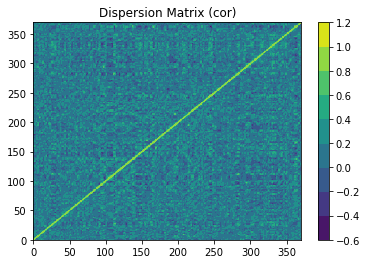

In [19]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [20]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 23 EOFs:
67.87% 

Cumulative variance explained by the first 4 EOFs:
25.31% 

1 	 11.31%
2 	 7.61%
3 	 6.39%
4 	 6.24%


### North Test

In [21]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[12.448  8.376  7.028  6.863  4.67   3.926]
[11.314  7.612  6.388  6.238  4.244  3.568]
[10.18   6.849  5.747  5.613  3.819  3.21 ]


### Fig 2: Variance

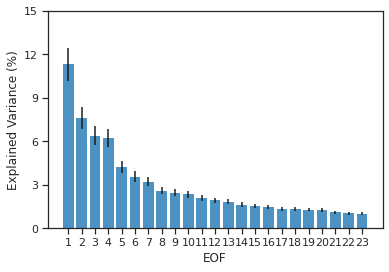

In [22]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [23]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(371, 19)
[[ 0.123  0.472  0.241 ... -0.055 -0.036  0.217]
 [ 0.031  0.325  0.005 ... -0.29  -0.041  0.395]
 [ 0.249 -0.201  0.167 ...  0.063 -0.239 -0.122]
 ...
 [-0.339  0.366 -0.077 ... -0.102 -0.11  -0.059]
 [ 0.089  0.059 -0.001 ...  0.178 -0.138 -0.075]
 [ 0.108  0.306  0.022 ...  0.035  0.165  0.059]]


### Save EOFs

In [24]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [25]:
# Calculate principal components (spatial modes)
neofs = 19
pcs = calc_pcs(Xs, evecs, neofs, mode=eofmode)

In [26]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var2.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [27]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting
lons = era_ar.lon.data
lats = era_ar.lat.data
udat = pcmodes[0][0:neofs,:,:]
vdat = pcmodes[1][0:neofs,:,:]
data = np.sqrt(udat**2 + vdat**2)
# data = vdat**2
print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

0.005637015422671075 39.40996286843753


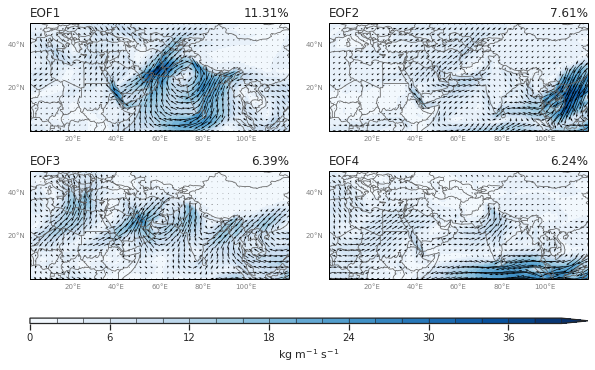

In [28]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Add contour fill plot
    clevs = np.arange(0,41,2)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="Blues", extend='max')
    # add vectors
    ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20)      
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('kg m$^{-1}$ s$^{-1}$', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/nash/DATA/repositories/AR_types/figs/pc_IVTt0120050cor.png


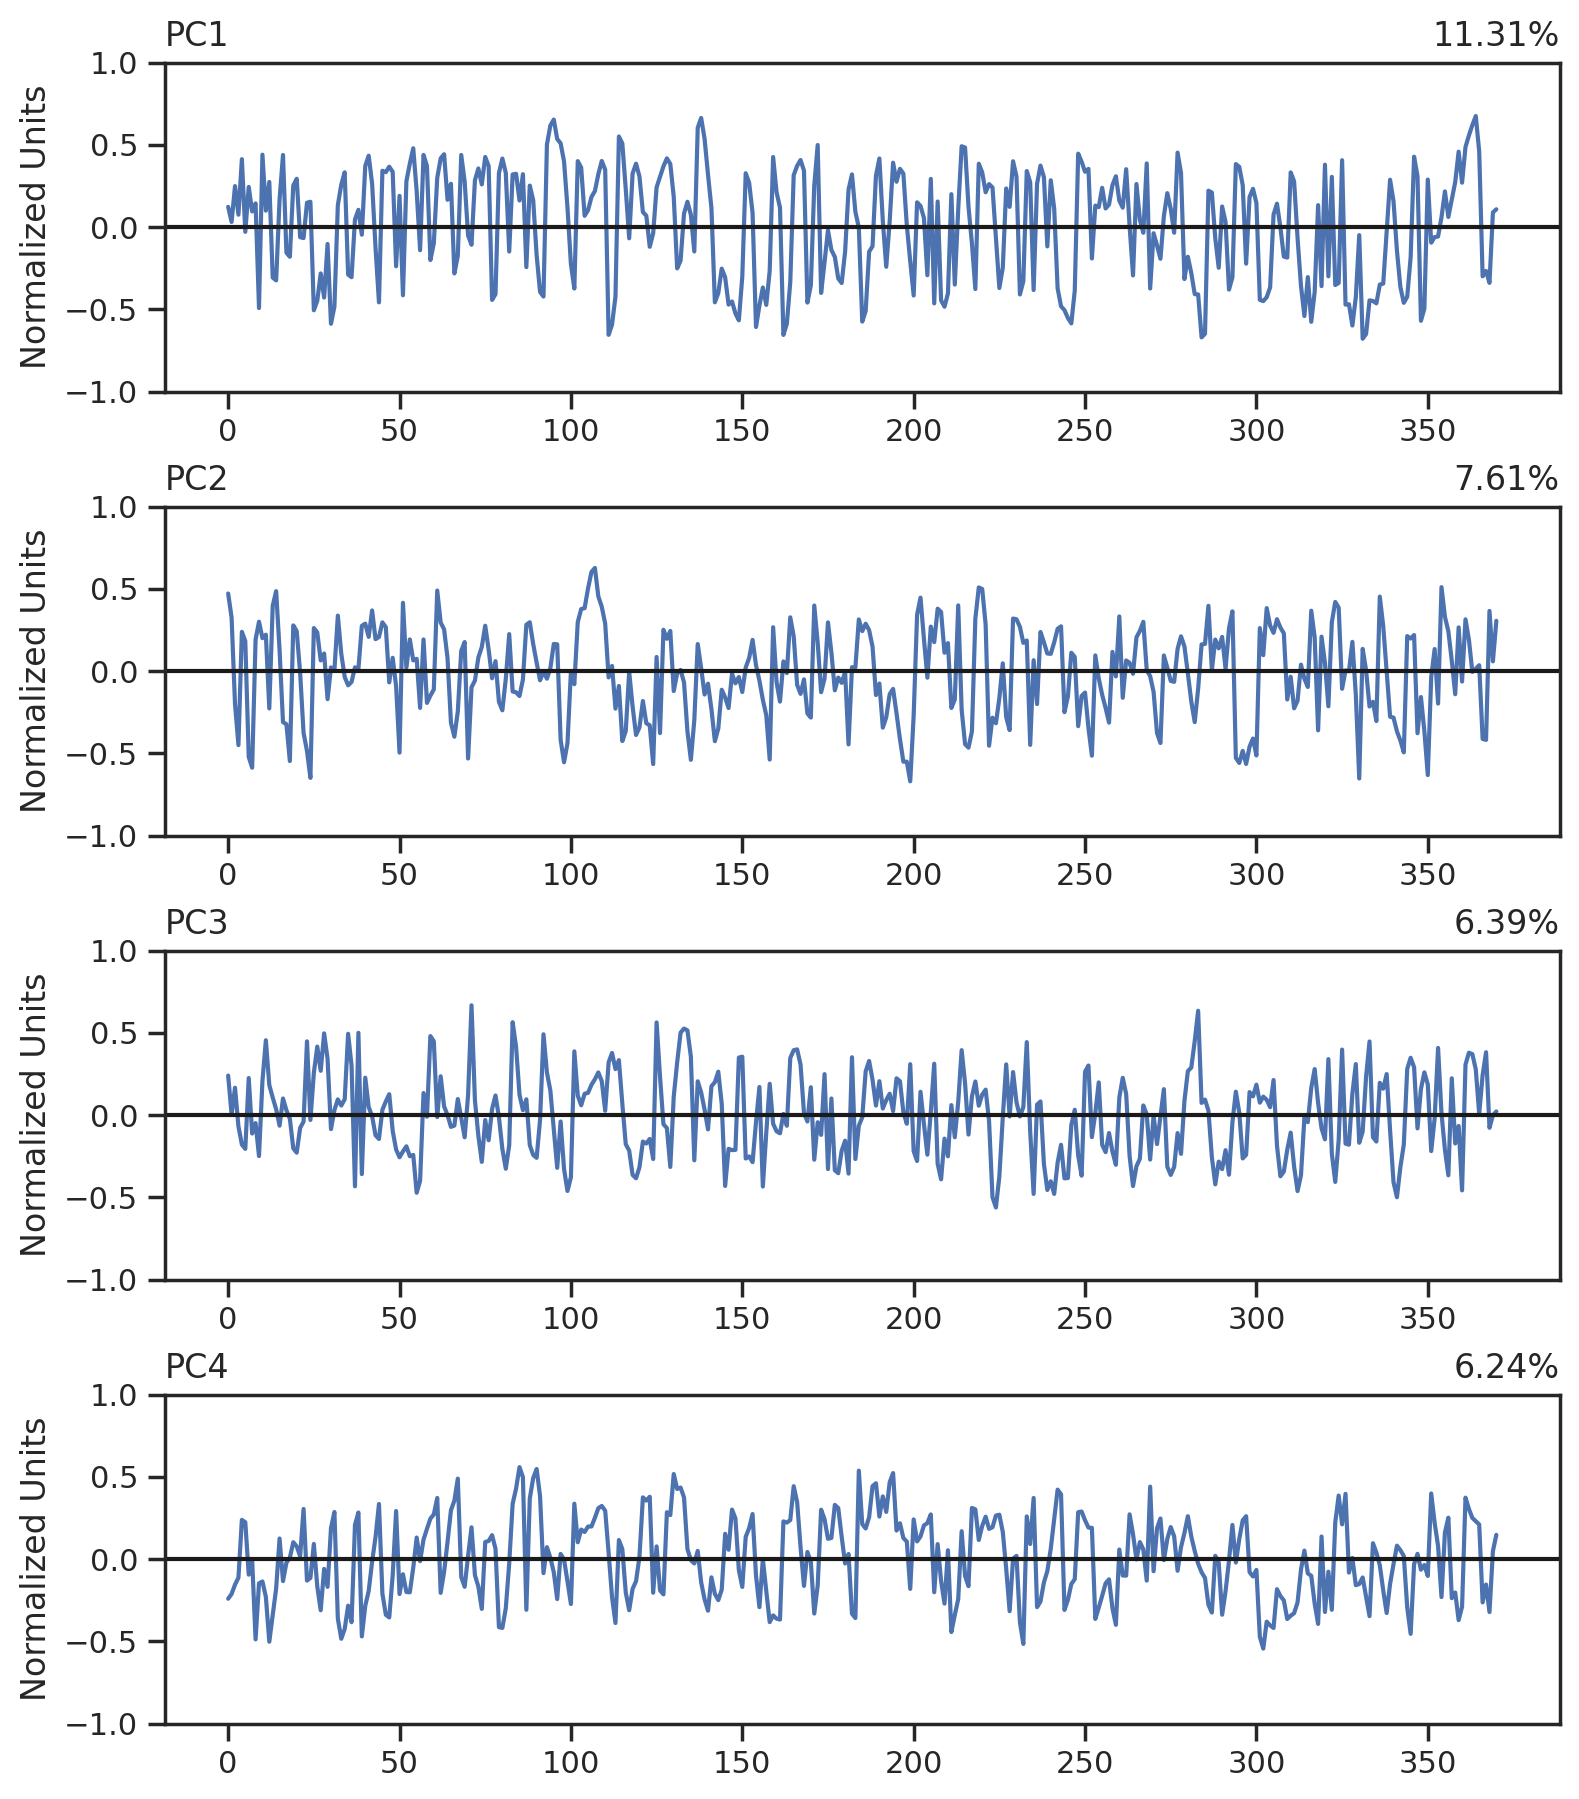

<Figure size 1800x2200 with 0 Axes>

In [30]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
# results = evecs[:,:4]
results = loads[:,:4]

X, nplots = results.shape
x = np.arange(len(results))

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot(x, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-1, 1)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### K-means clustering

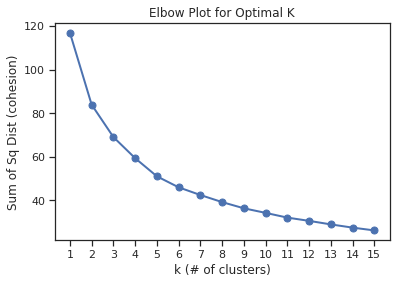

In [29]:
# Determine optimal K

# maximum number of clusters (number of iterations)
kmax =15
# number of eofs
neofs = 4
# input data
xdata = loads[:,0:neofs]

# Elbow plot
outfile = path_to_figs + 'elbow'+ fname_id
plot_optimal_k(xdata, kmax, filename=outfile)


In [ ]:
## K-means cluster analysis

# Number of clusters
nk = 4

# Input data
xdata = loads[:,0:neofs]

# Compute k means and assign each point to a cluster
kmeans = KMeans(n_clusters=nk)
kmeans.fit(xdata)
cluster = kmeans.predict(xdata)

# LLJ category labels (llj days only)
ar_cat = cluster + 1


In [30]:
# Count number of days in each cluster
klabels, counts = np.unique(ar_cat, return_counts=True)

# Save counts to txt file
res = np.column_stack((klabels,counts))
headstr = 'AR_TYPE, COUNT'
outfile = path_to_out + fname_id + 'k_counts.txt'
np.savetxt(outfile, res, delimiter=',', fmt='%d', header=headstr)



In [32]:
# Cluster centroids (nclust x neofs)
centroids = kmeans.cluster_centers_

# Save centroids to txt file
res = np.column_stack((klabels,centroids))
headstr = "AR_TYPE, EOF1, EOF2, EOF3, EOF4"
outfile = path_to_out + fname_id + 'centroids.txt'
np.savetxt(outfile, res, delimiter=',', fmt='%s', header=headstr)


### Save AR Category Labels

In [33]:
## Save AR location, loadings (EOF1-4), and category label (AR days only)

# Vector of AR dates
dates_arDays = era_ar.time.values

# Create new dataframe
data = {'LOC':era_ar.location.values,
        'EOF1':loads[:,0],
        'EOF2':loads[:,1],
        'EOF3':loads[:,2],
        'EOF4':loads[:,3],
        'AR_CAT':ar_cat}
df_out = pd.DataFrame(data, index=dates_arDays)
print(df_out)

# Export dataframe as csv
outfile = path_to_out + fname_id + 'hma_AR-types-loadings.csv'
df_out.to_csv(outfile)


                     LOC      EOF1      EOF2      EOF3      EOF4  AR_CAT
1979-12-01 09:00:00  R03  0.122797  0.471932  0.240628 -0.240623       1
1979-12-02 09:00:00  R01  0.031309  0.325484  0.005130 -0.211536       1
1980-01-24 09:00:00  R01  0.249166 -0.200858  0.166610 -0.154746       4
1980-01-25 09:00:00  R01  0.075211 -0.450026 -0.068609 -0.112488       4
1980-02-12 09:00:00  R01  0.412940  0.238788 -0.178651  0.238738       1
...                  ...       ...       ...       ...       ...     ...
2017-02-21 09:00:00  R03 -0.299781 -0.412616  0.243904 -0.262965       2
2017-02-22 09:00:00  R03 -0.267057 -0.418341  0.382472 -0.154409       2
2017-12-05 09:00:00  R02 -0.339433  0.365694 -0.076962 -0.321719       2
2018-02-14 09:00:00  R01  0.088909  0.059164 -0.000952  0.049006       1
2018-02-26 09:00:00  R01  0.108265  0.305859  0.022486  0.147808       1

[371 rows x 6 columns]


In [34]:
## Save time series of all DJF days with AR types

# Arrays with ALL DJF days
dates_allDays = era.time.values
ar_cat_allDays = np.zeros(len(dates_allDays), dtype=int)

# Loop over ar days and match to ar_full 
for i, date in enumerate(dates_arDays):
    idx = np.where(dates_allDays == date)
    ar_cat_allDays[idx] = ar_cat[i]  

# Create dataframe
data = {'AR_CAT':ar_cat_allDays}
df_out = pd.DataFrame(data, index=dates_allDays)
print(df_out)

outfile = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df_out.to_csv(outfile)


                     AR_CAT
1979-12-01 09:00:00       1
1979-12-02 09:00:00       1
1979-12-03 09:00:00       0
1979-12-04 09:00:00       0
1979-12-05 09:00:00       0
...                     ...
2018-02-24 09:00:00       0
2018-02-25 09:00:00       0
2018-02-26 09:00:00       1
2018-02-27 09:00:00       0
2018-02-28 09:00:00       0

[3520 rows x 1 columns]
